## ** A New Non-intrusive Load Monitoring Method for Residential Appliances **

- Author : Gyubaek Kim (database.kim@yonsei.ac.kr)
- Description
  * Various algorithms have been utilized by NILM systems. The benchmark project used adopted neural network-based algorithms. The neural 
  network-based algorithms performed better than existing combinational optimization and hidden Markov models. Thus, we compared the 
  performance of the models produced by the proposed method with the neural network-based algorithms. We used random forest and gradient 
  boosting machine (GBM), the representative decision tree-based ensemble models, in the proposed method.
- License
   * All rights reserved. No part of this code may be reproduced or transmitted in any form or by any means, or utilized by any information storage and retrieval system without written permission from the copyright owner. You can use this source code for free projects only. I will not allow commercial use of this code. I am not allowing anyone to modify any or all parts of the source code for commercial purposes. By using my source code, you agree to the following: 
       * 1. You will not distribute any or all parts of this source code for commercial use 
       * 2. You will cite me as the original creator of this source code. 
       * 3. You will inform me of its use before you use any or all parts of this source code. 
   For use of any or all parts of this source code, email me. This source code is provided free to use for everybody provided this is used non-commercially. Violators of this agreement will be subject to legal action by the author. If you see commercial applications or software using any or all parts of this source code, inform me.  

#### import packages of benchmark project (contrib. project) to be compared

- https://github.com/OdysseasKr/neural-disaggregator
- The project implemented 5 neural network-based NILM models
  * RNN (Recurrent Neural Network)
  * GRU (Gated Recurrent Unit)
  * Window GRU
  * DAE (Denosing Autoencoder)
  * S2P (Short Sequence to Point)

In [1]:
#### NIMLTK as common framework ####
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
from nilmtk import DataSet

#### Benchmark Resource ####
from benchmark.rnndisaggregator import RNNDisaggregator
from benchmark.grudisaggregator import GRUDisaggregator
from benchmark.windowgrudisaggregator import WindowGRUDisaggregator
from benchmark.daedisaggregator import DAEDisaggregator
from benchmark.shortseq2pointdisaggregator import ShortSeq2PointDisaggregator
from benchmark.metrics import recall_precision_accuracy_f1, relative_error_total_energy, mean_absolute_error

from work.benchmark.rnndisaggregator_fe import RNNDisaggregatorFE
from work.benchmark.grudisaggregator_fe import GRUDisaggregatorFE
from work.benchmark.windowgrudisaggregator_fe import WindowGRUDisaggregatorFE
from work.benchmark.daedisaggregator_fe import DAEDisaggregatorFE
from work.benchmark.shortseq2pointdisaggregator_fe import ShortSeq2PointDisaggregatorFE

#### Our Model ####
from work.dtdisaggregator import DTDisaggregator
from work.utils import checkSimilarity

import pandas as pd
import numpy as np
import h5py
import numpy.random
import time
import datetime
import math
import itertools
import warnings

from scipy.signal import find_peaks

from matplotlib import rcParams
import matplotlib.pyplot as plt

numpy.random.seed(42)
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = (23, 10)

/home/kgbmanse/anaconda3/envs/nilm/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


#### Configuration

In [5]:
###############################################################
# Common
###############################################################
TRAIN_SAMPLE_PERIOD = 6
TEST_SAMPLE_PERIOD = 6

EPOCHS = 1

DATA_FILE = 'data/enertalk.h5'

T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-31'

HOME_ID = 1
appliances = ['television', 'washing machine', 'rice cooker', 'water filter', 'microwave']

In [3]:
# start_time, end_time : YYYY-MM-DD HH:MI:SS
def disaggregate(dataset, model, appliance, start_time, end_time, evaluate=False):
    
    dataset.set_window(start=start_time, end=end_time)
    
    test_elec = dataset.buildings[HOME_ID].elec    
    test_mains = test_elec.all_meters()[0]   
    test_meter = test_elec.submeters()[appliance]
    
    tempfile = 'work/temp/' + str(time.time())
    
    output = HDFDataStore(tempfile, 'w')    
    model.disaggregate(test_mains, output, test_meter, sample_period=TEST_SAMPLE_PERIOD)
    output.close()
    
    result = DataSet(tempfile)    
    res_elec = result.buildings[HOME_ID].elec

    predicted = res_elec[appliance] 
    
    ground_truth = None
   
    if evaluate == True:
        
        ground_truth = test_elec[appliance]

        # Performance Metric
        print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
        print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))

## [1] Alogorithm Comparison with No Feature

- Description
  In the first evaluation, only total electricity consumption was used as training data without feature engineering.

In [4]:
dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]
    
    models = {}
    
    models['GRU-' + aname] = GRUDisaggregator()
    models['RNN-' + aname] = RNNDisaggregator()
    models['WGRU-' + aname] = WindowGRUDisaggregator(window_size=50)
    models['DAE-' + aname] = DAEDisaggregator(256)
    models['S2P-' + aname] = ShortSeq2PointDisaggregator(window_size=100)
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=False, reactive=False)
    models['GBM-' + aname] = DTDisaggregator(algorithm='GBM', use_feature=False, reactive=False)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))
            
            disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)
            

2021-10-07 09:10:47.944681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-10-07 09:10:47.946383: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-10-07 09:10:47.946430: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-07 09:10:47.947071: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Libra

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 50, 16)            80        
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 128)           31488     
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               198144    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

2021-10-07 09:11:33.382413: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2096/2096 [==============================] - 31s 12ms/step - loss: 9.2092e-05
elapsed time (secs) = 73.30106353759766
New sensible chunk: 59604
New sensible chunk: 28957
New sensible chunk: 55356
============ Relative error in total energy: 0.1952924641038005
============ Mean absolute error(in Watts): 30.646581291558302
********************
[RNN-television]
********************
1125/1125 [==============================] - 22s 16ms/step - loss: 1.2995e-04
elapsed time (secs) = 42.594058990478516
New sensible chunk: 59604
New sensible chunk: 28957
New sensible chunk: 55356
============ Relative error in total energy: 0.1959565352293293
============ Mean absolute error(in Watts): 33.14815205263885
********************
[WGRU-television]
********************
1125/1125 [==============================] - 220s 192ms/step - loss: 1.1479e-04
elapsed time (secs) = 240.45067977905273
New sensible chunk: 59604
New sensible chunk: 28957
New sensible chunk: 55356
============ Relative error in total

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 100, 30)           330       
_________________________________________________________________
dropout_46 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 100, 30)           7230      
_________________________________________________________________
dropout_47 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 100, 40)           7240      
_________________________________________________________________
dropout_48 (Dropout)         (None, 100, 40)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 100, 50)         

********************
[GRU-microwave]
********************
1125/1125 [==============================] - 15s 10ms/step - loss: 3.9395e-04
elapsed time (secs) = 36.44890475273132
New sensible chunk: 59604
New sensible chunk: 28957
New sensible chunk: 55356
============ Relative error in total energy: 0.2924628092076531
============ Mean absolute error(in Watts): 10.51943701632749
********************
[RNN-microwave]
********************
1125/1125 [==============================] - 22s 16ms/step - loss: 4.1368e-04
elapsed time (secs) = 43.122820138931274
New sensible chunk: 59604
New sensible chunk: 28957
New sensible chunk: 55356
============ Relative error in total energy: 0.05300522919396126
============ Mean absolute error(in Watts): 11.62148591064579
********************
[WGRU-microwave]
********************
1125/1125 [==============================] - 217s 189ms/step - loss: 3.7372e-04
elapsed time (secs) = 237.60797500610352
New sensible chunk: 59604
New sensible chunk: 28957
New se

## [2] Alogorithm Comparison with Features

- Description
  It divides the preceding 1 minute into units of 6 seconds each, resulting in 10 consecutive data series in the form of a sliding window. 
  The 6-second interval was experimentally determined. Intervals of less than 6 seconds resulted in overly sensitive predictions and 
  degraded performance while those of more than 6 seconds were unable to capture all of the characteristics of residential appliances. The 
  data in each window consisted of 28 features, 
  * including 10 active power features; 
  * 10 Fourier transformed results that correspond to 10 active powers representing frequency domain characteristics; 
  * and 8 statistical features, namely maximum, minimum, difference between maximum and minimum, mean, standard deviation, 25% quartile, 
    50% quartile, and 75% quartile for the 10 active power features.

2021-10-08 16:25:17.397090: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-10-08 16:25:17.398760: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-10-08 16:25:17.398814: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-08 16:25:17.399434: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Libra

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 100, 30)           8430      
_________________________________________________________________
dropout (Dropout)            (None, 100, 30)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 30)           7230      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 30)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 40)           7240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 40)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 50)           1

2021-10-08 19:09:06.706521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2095/2095 [==============================] - 91s 43ms/step - loss: 0.0038
elapsed time (secs) = 9920.423176765442
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
============ Relative error in total energy: 0.20843966352539042
============ Mean absolute error(in Watts): 10.815334770380193
********************
[DRF-microwave]
********************


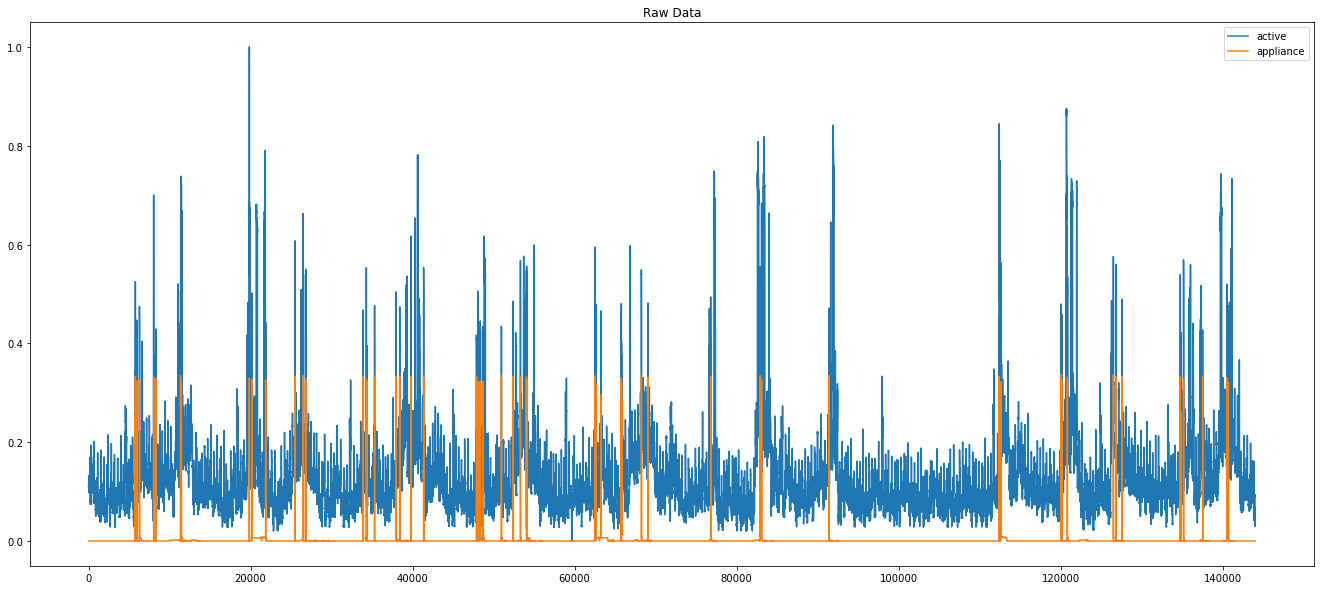

feature selection is done..
model fit is done..
diff    0.373308
a9      0.175107
f6      0.066936
f4      0.036244
std     0.032374
a8      0.028797
f5      0.027916
max     0.026865
a1      0.025006
min     0.023762
f2      0.019306
f8      0.017891
q1      0.014931
q2      0.013114
a6      0.012414
f1      0.012159
a7      0.011285
f9      0.010808
q0      0.010127
a0      0.009942
f7      0.008632
f3      0.008321
a4      0.008171
a2      0.006585
a5      0.006547
a3      0.006344
mean    0.004079
f0      0.003028
dtype: float64


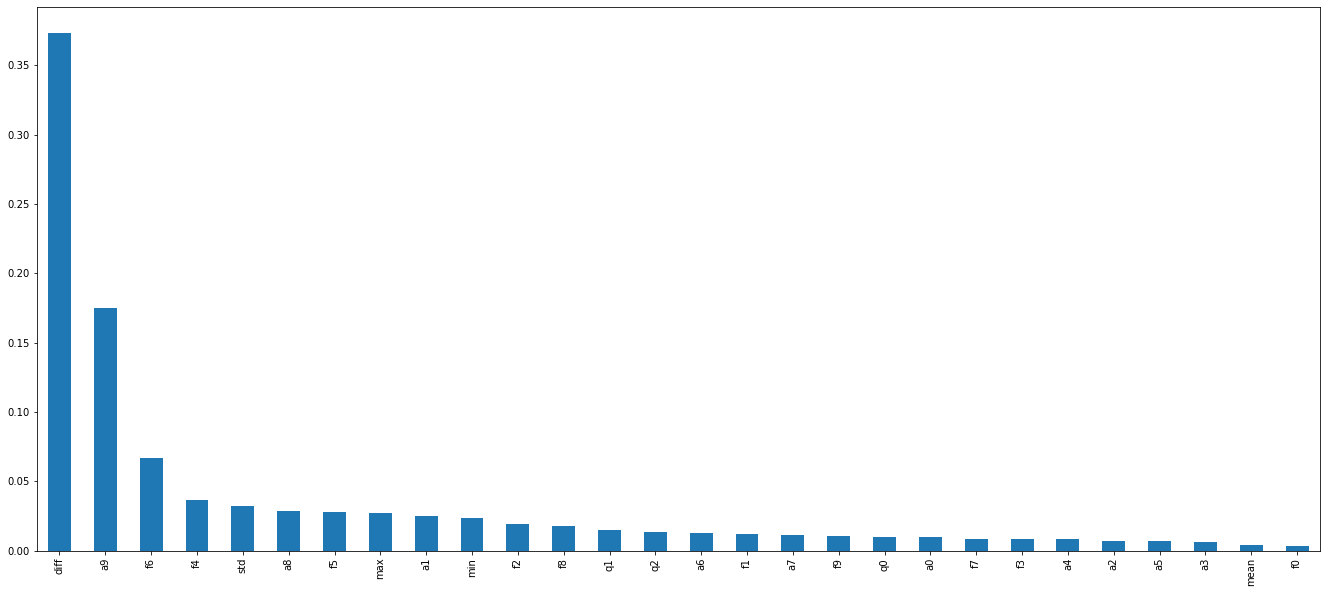

train on chunk is done..
elapsed time (secs) = 918.8489727973938
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.008796277386876843
============ Mean absolute error(in Watts): 1.5240860511850942
********************
[GBM-microwave]
********************


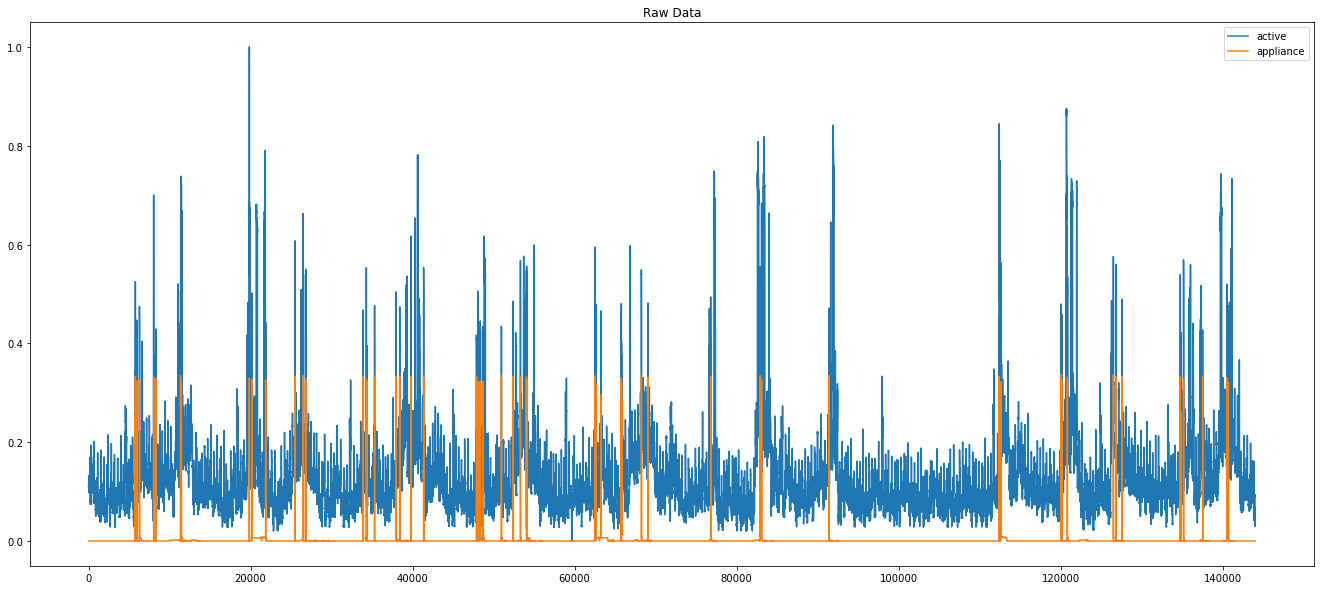

feature selection is done..
model fit is done..
diff    0.437653
a9      0.227217
f4      0.075854
max     0.034181
std     0.031717
f6      0.029198
f5      0.026740
min     0.020504
a1      0.018170
f2      0.017893
f8      0.015914
a6      0.013455
a8      0.010982
q1      0.005680
q2      0.004667
f1      0.004273
f7      0.004157
a4      0.003509
q0      0.003446
f3      0.003442
f9      0.003329
a2      0.002802
a0      0.001504
a7      0.001492
f0      0.001411
a3      0.000436
a5      0.000338
mean    0.000036
dtype: float64


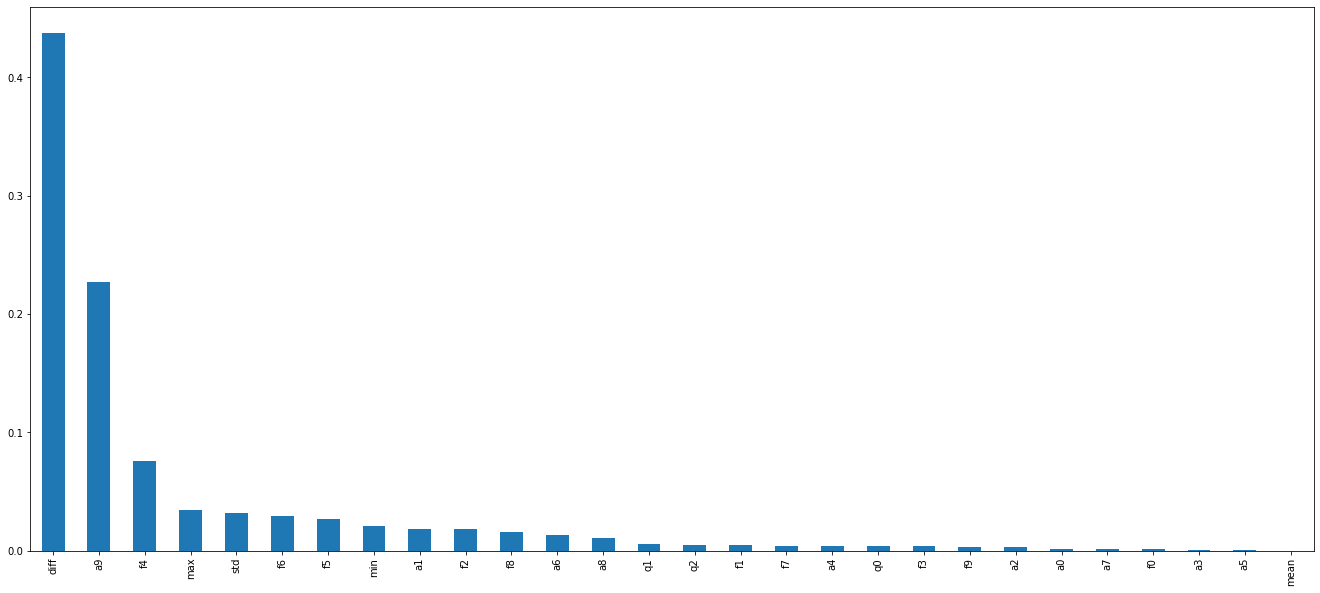

train on chunk is done..
elapsed time (secs) = 225.439772605896
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.009030689035808922
============ Mean absolute error(in Watts): 5.401100899403116


In [4]:
dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]
    
    models = {}
    
    models['GRU-' + aname] = GRUDisaggregatorFE()
    models['RNN-' + aname] = RNNDisaggregatorFE()
    models['WGRU-' + aname] = WindowGRUDisaggregatorFE(window_size=50)
    models['DAE-' + aname] = DAEDisaggregatorFE(256)
    models['S2P-' + aname] = ShortSeq2PointDisaggregatorFE(window_size=100)
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
    models['GBM-' + aname] = DTDisaggregator(algorithm='GBM', use_feature=True, reactive=False)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))

            disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)
  

## [3] Alogorithm Comparison with Features + reactive

- description
  Thirty reactive power and derivative features were added of which 10 were reactive power features, 10 were apparent power features, and 
  10 were power factor features for a total of 58 features.

********************
[DRF-television]
********************
elapsed time (secs) = 75.9982488155365
train & test error 'RandomForestRegressor' object has no attribute 'estimators_'
********************
[DRF-washing machine]
********************


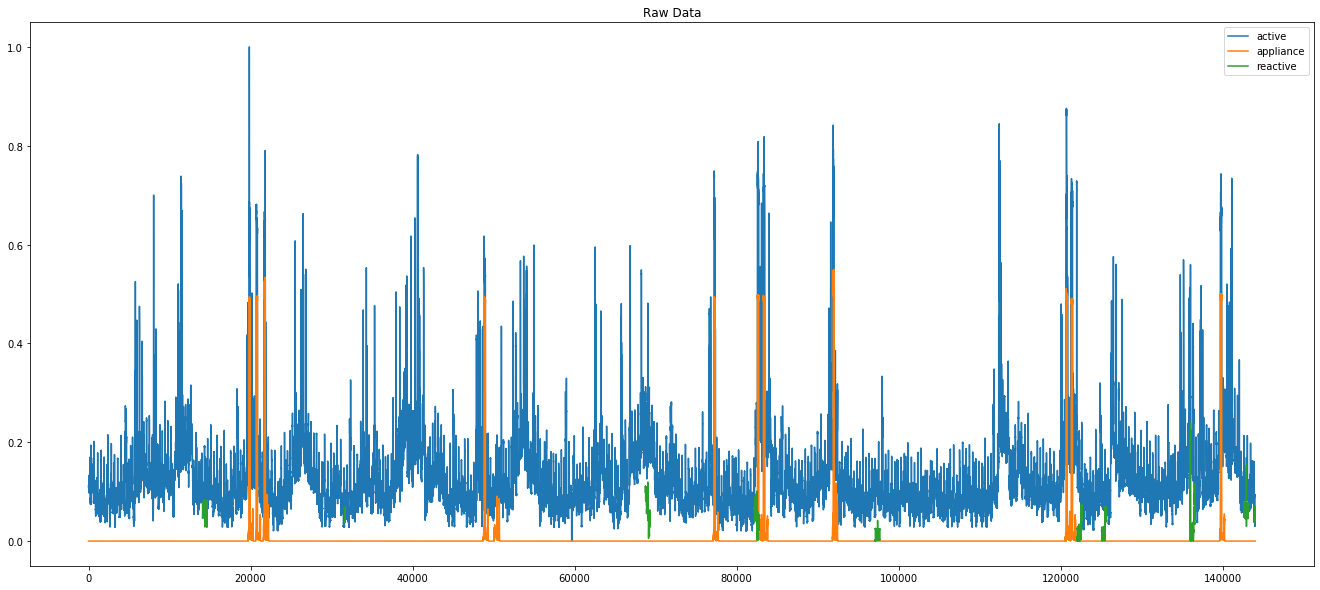

feature selection is done..
model fit is done..
min     8.833279e-01
diff    3.440487e-02
a9      1.325452e-02
std     1.200755e-02
ap9     1.081994e-02
f5      5.758173e-03
max     3.969571e-03
q0      2.551597e-03
q2      2.520546e-03
ap0     2.517532e-03
f1      2.331087e-03
f9      2.074018e-03
a0      2.056841e-03
f2      1.900302e-03
f7      1.736451e-03
f6      1.693369e-03
f4      1.641503e-03
f8      1.591696e-03
q1      1.542846e-03
f3      1.489902e-03
ap1     1.012020e-03
a8      7.555287e-04
ap8     7.421066e-04
a1      6.513592e-04
a3      6.224518e-04
a2      6.125435e-04
a7      6.090274e-04
a6      5.820426e-04
ap6     5.783877e-04
ap3     5.638137e-04
a4      5.461345e-04
ap7     5.336861e-04
ap5     5.237952e-04
ap4     4.991096e-04
mean    4.667284e-04
a5      4.502707e-04
ap2     4.361575e-04
f0      4.240491e-04
pf0     3.093646e-05
pf8     3.045910e-05
r9      2.179759e-05
r8      1.659787e-05
r0      1.479444e-05
pf2     1.299081e-05
r7      1.146621e-05
pf9    

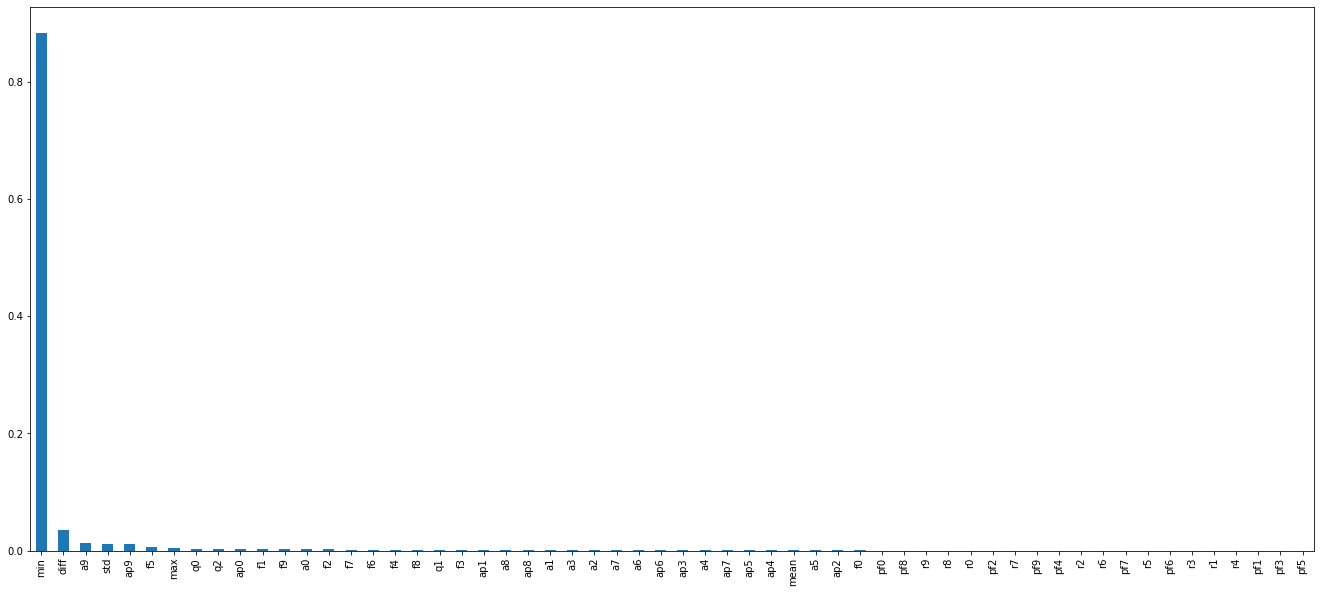

train on chunk is done..
elapsed time (secs) = 1511.6513557434082
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.01305835120450773
============ Mean absolute error(in Watts): 1.98642635077915
********************
[DRF-rice cooker]
********************


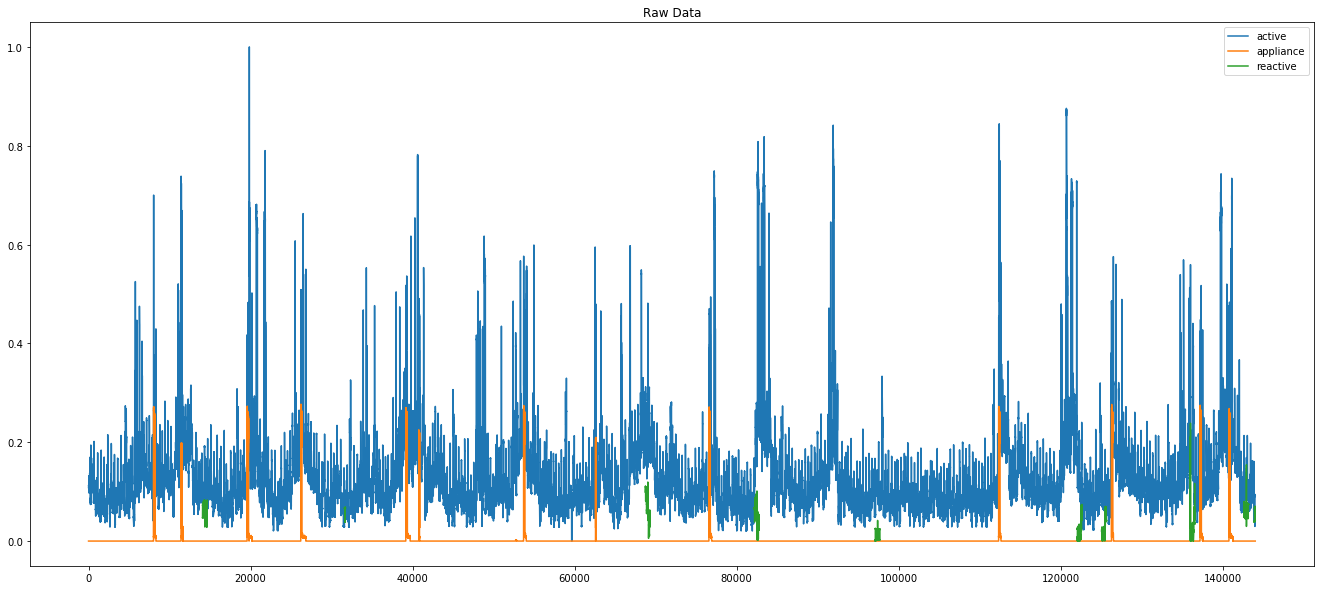

feature selection is done..
model fit is done..
ap9     2.729558e-01
a9      2.343013e-01
min     1.127730e-01
max     9.993079e-02
diff    3.887276e-02
std     2.771301e-02
ap8     1.829174e-02
a1      1.670619e-02
ap1     1.498263e-02
pf9     1.460022e-02
q2      1.381533e-02
q1      1.281903e-02
q0      1.013060e-02
f4      7.312843e-03
f6      6.584970e-03
f5      5.991814e-03
f3      5.484152e-03
a0      5.159106e-03
f7      5.000654e-03
ap0     4.916036e-03
a8      4.701980e-03
f1      4.700603e-03
mean    4.509198e-03
f9      4.467194e-03
f8      4.290945e-03
f2      4.290929e-03
ap4     4.143512e-03
f0      4.042688e-03
a6      3.505132e-03
ap6     3.270421e-03
a4      3.159589e-03
a2      3.049959e-03
a7      3.044900e-03
ap7     3.013290e-03
ap2     2.760260e-03
ap3     2.707289e-03
ap5     2.640234e-03
a3      2.164573e-03
pf8     2.087530e-03
a5      2.041906e-03
pf7     1.247498e-03
pf6     5.600553e-04
pf5     3.668960e-04
pf4     3.117174e-04
pf1     2.397305e-04
pf3    

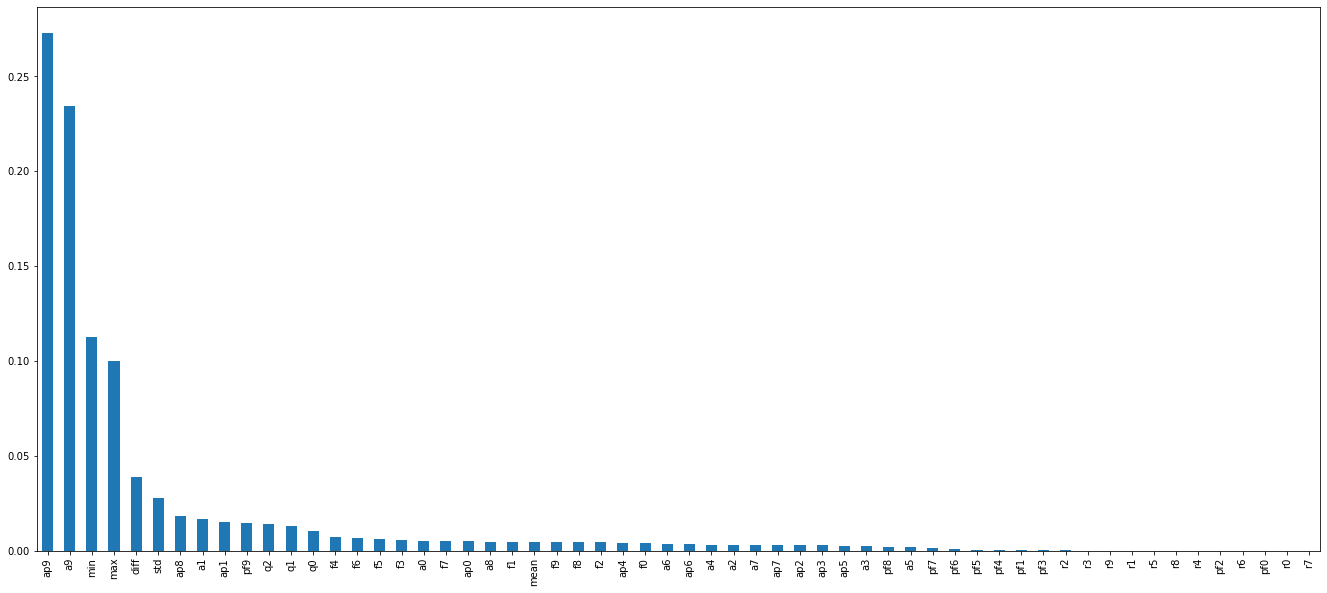

train on chunk is done..
elapsed time (secs) = 1382.756930589676
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.003633655264998907
============ Mean absolute error(in Watts): 1.2705963524890838
********************
[DRF-water filter]
********************


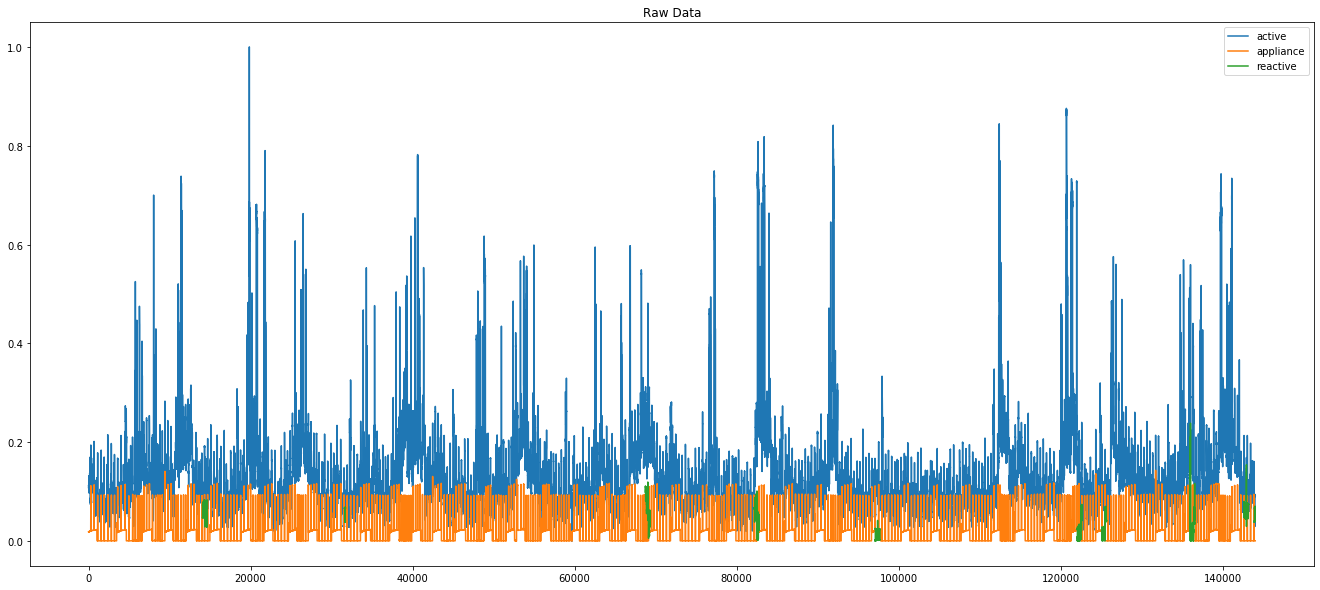

feature selection is done..
model fit is done..
a9      0.206816
diff    0.110105
min     0.094840
max     0.077982
a0      0.061784
std     0.034018
ap0     0.028484
ap9     0.028426
f5      0.023810
q0      0.023079
q2      0.020171
q1      0.017996
ap8     0.017255
f4      0.014993
f6      0.014474
a8      0.013431
f9      0.012306
f2      0.012127
f1      0.011879
f7      0.011795
f8      0.011490
a1      0.011323
f3      0.011272
ap1     0.010869
ap7     0.009477
a7      0.008538
ap6     0.008108
a2      0.007966
ap2     0.007843
ap5     0.007603
ap3     0.007573
a6      0.007079
ap4     0.006967
a3      0.006883
f0      0.006724
a4      0.006714
mean    0.006274
a5      0.006260
r0      0.002041
pf9     0.001823
r9      0.001238
pf0     0.001161
r2      0.000859
r1      0.000851
pf8     0.000827
pf1     0.000641
pf7     0.000597
pf2     0.000570
r3      0.000563
pf4     0.000540
r4      0.000534
r8      0.000484
pf3     0.000475
pf6     0.000444
r7      0.000438
r6      0.000412


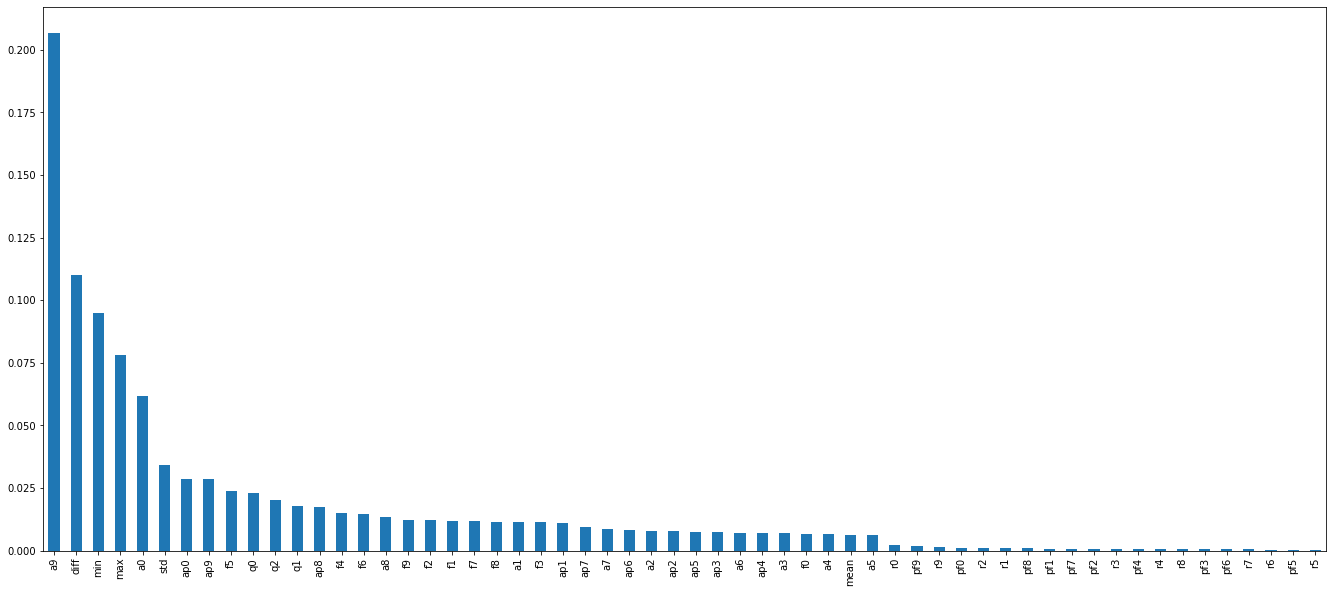

train on chunk is done..
elapsed time (secs) = 861.2089779376984
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.010540891577097328
============ Mean absolute error(in Watts): 11.504348334130855
********************
[DRF-microwave]
********************


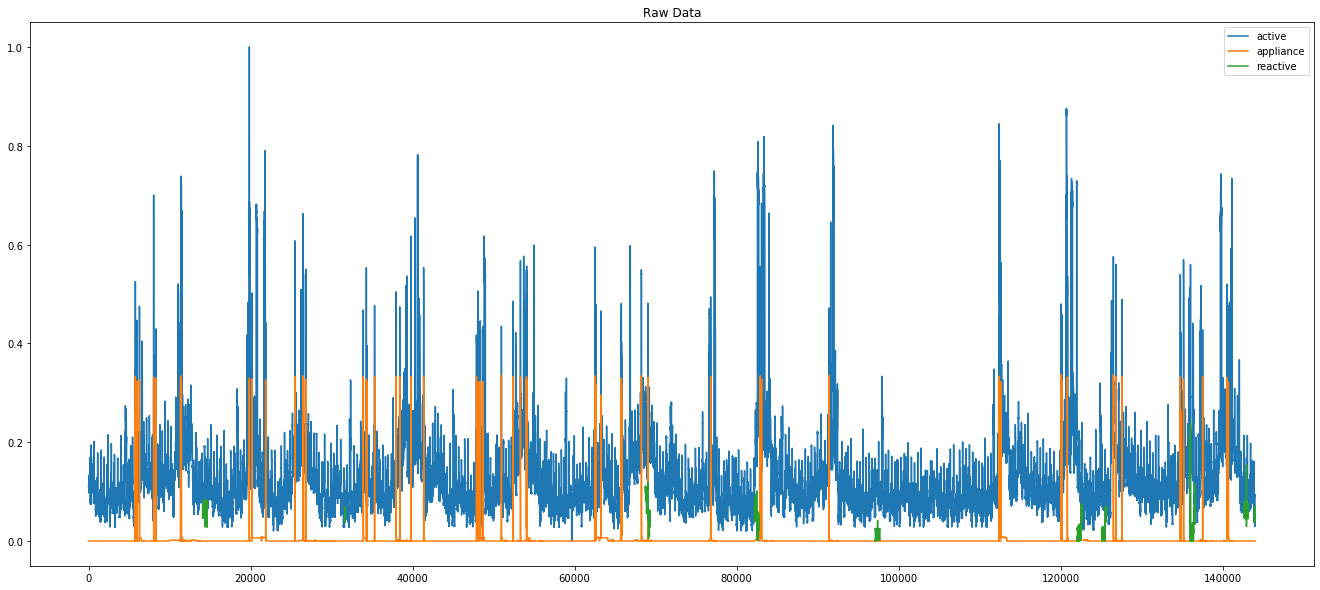

feature selection is done..
model fit is done..
diff    0.364378
ap9     0.094785
a9      0.076526
f4      0.074916
f6      0.045566
std     0.036353
f5      0.024857
max     0.022398
f8      0.021142
f2      0.017751
min     0.017016
a8      0.015421
q2      0.013580
ap8     0.013140
ap1     0.012715
a1      0.012225
q1      0.012179
f9      0.010073
f1      0.009976
f3      0.009495
q0      0.009443
f7      0.008495
a6      0.007832
ap0     0.007388
ap7     0.006704
a0      0.006088
ap6     0.005577
a7      0.005012
ap4     0.004670
a2      0.004245
ap2     0.004224
a4      0.003677
mean    0.003401
a5      0.003003
ap3     0.002929
a3      0.002807
ap5     0.002784
f0      0.002660
pf9     0.001063
r5      0.000559
r7      0.000521
r6      0.000438
r8      0.000419
r9      0.000368
r4      0.000339
pf8     0.000331
pf5     0.000155
pf7     0.000111
pf3     0.000106
pf4     0.000065
r2      0.000041
pf1     0.000033
r1      0.000005
r0      0.000004
pf0     0.000003
r3      0.000002


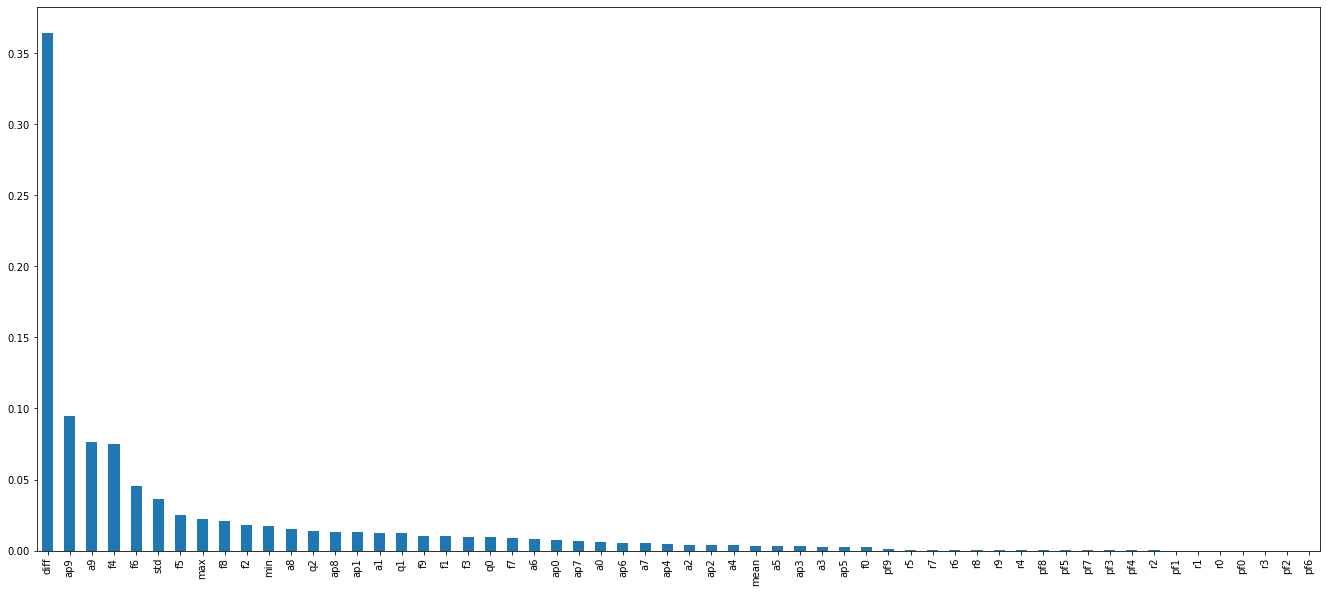

train on chunk is done..
elapsed time (secs) = 1280.7501566410065
New sensible chunk: 59604
feature selection is done..
New sensible chunk: 28957
feature selection is done..
New sensible chunk: 55356
feature selection is done..
Disaggregation is done..
============ Relative error in total energy: 0.007373138325561412
============ Mean absolute error(in Watts): 1.5301415218193173


In [6]:
dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]
    
    models = {}
    
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=True)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))

            disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)
  